In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
from explainerdashboard import ExplainerDashboard, ClassifierExplainer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import captum.attr as c
import time
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import os
from imblearn.over_sampling import SMOTE
import joblib

In [14]:
def plot_confusion_matrix(actual_labels, predicted_labels):
    """
    Plot confusion matrix with labels.
    """
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [15]:
data = pd.read_csv('../Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_2880\3121833706.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.


In [16]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [17]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [18]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [19]:
ohe1 = pd.read_csv('../Full_proto_encoded.csv')
ohe2 = pd.read_csv('../Full_dsport_encoded.csv')
ohe3 = pd.read_csv('../Full_service_encoded.csv')
ohe4 = pd.read_csv('../Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('../Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('../Full_sport_encoded.csv')
ohe7 = pd.read_csv('../Full_dstip_encoded.csv')

In [20]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Archive.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [ ]:
class NNsmote(nn.Module):
    def __init__(self, n_features, fc_size, device, save_dir, name):
        super(NNsmote, self).__init__()
        self.name = name
        self.device = device
        self.save_dir = save_dir
        self.fc1 = nn.Linear(n_features, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)
        self.activation1 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.to(self.device)

        self.train_loss = []
        self.train_accuracy = []
        self.train_f1 = []
        self.test_accuracy = None
        self.test_loss = None
        self.test_f1 = None
        self.test_predicted = []
        self.epoch_time = []

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

    def calculate_accuracy_f1(self, predictions, labels):
        preds = (predictions > 0.5).float()
        accuracy = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        return accuracy, f1

    def run(self, train_loader, criterion, optimizer, epochs, save_factor):
        for epoch in range(epochs):
            start_time = time.time()
            self.train()
            epoch_loss = 0
            epoch_accuracy = 0
            epoch_f1 = 0
            num_batches = len(train_loader)

            for _, (train_seq, train_label) in tqdm(
                enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):

                train_seq, train_label = train_seq.to(self.device), train_label.to(self.device)
                batch_size = len(train_seq)
                smote_neighbors = min(batch_size, 2)

                if batch_size > 1:
                    try:
                        smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                        train_smote, train_label_smote = smote.fit_resample(
                            train_seq.cpu().numpy(), train_label.cpu().numpy())
                        train_smote = torch.tensor(train_smote, dtype=torch.float32).to(self.device)
                        train_label_smote = torch.tensor(train_label_smote, dtype=torch.float32).to(self.device)
                    except ValueError:
                        print('Error running SMOTE.')
                        train_smote, train_label_smote = train_seq, train_label
                else:
                    train_smote, train_label_smote = train_seq, train_label

                optimizer.zero_grad()
                outputs = self(train_smote)
                loss = criterion(outputs.squeeze(), train_label_smote)
                loss.backward()
                optimizer.step()

                acc, f1 = self.calculate_accuracy_f1(outputs, train_label_smote)
                epoch_loss += loss.item()
                epoch_accuracy += acc
                epoch_f1 += f1

            self.train_loss.append(epoch_loss / num_batches)
            self.train_accuracy.append(epoch_accuracy / num_batches)
            self.train_f1.append(epoch_f1 / num_batches)
            self.epoch_time.append(time.time() - start_time)

            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {self.train_loss[-1]:.4f}, Train Acc: {self.train_accuracy[-1]:.4f}, Train F1: {self.train_f1[-1]:.4f}")

            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)

    def test(self, test_loader, criterion):
        self.eval()
        self.test_predicted = []
        test_loss = 0
        test_accuracy = 0
        test_f1 = 0
        num_batches = len(test_loader)

        with torch.no_grad():
            for test_seq, test_label in tqdm(test_loader, total=num_batches, desc="Testing", unit="batch"):
                test_seq, test_label = test_seq.to(self.device), test_label.to(self.device)
                test_outputs = self(test_seq)
                loss = criterion(test_outputs.squeeze(), test_label)
                accuracy, f1 = self.calculate_accuracy_f1(test_outputs, test_label)
                test_loss += loss.item()
                test_accuracy += accuracy
                test_f1 += f1
                preds = (test_outputs > 0.5).float()
                self.test_predicted.extend(preds.cpu().numpy())

        self.test_loss = test_loss / num_batches
        self.test_accuracy = test_accuracy / num_batches
        self.test_f1 = test_f1 / num_batches

        print(f"Test Loss: {self.test_loss:.4f}, Test Accuracy: {self.test_accuracy:.4f}, Test F1: {self.test_f1:.4f}")

    def save_model(self, epoch):
        path = os.path.join(self.save_dir, f"PB_epoch_{epoch}.pkl")
        joblib.dump(self, path)

    def load_model(self, path):
        model = joblib.load(path)
        model.to(model.device)
        return model

In [ ]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

In [38]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fully_connected_size = 128
save_dir = './saved_models/'
model_name = 'PrimaryBinary'
model1 = NNsmote(n_features=n_features, fc_size=fully_connected_size, device=device, save_dir=save_dir, name=model_name)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.1)

model1.run(train_loader, criterion, optimizer, epochs=5, save_factor=1)
model1.test(test_loader, criterion)

Epoch 1/5: 100%|██████████| 15876/15876 [04:17<00:00, 61.67batch/s]


Error running SMOTE.
Epoch [1/5], Train Loss: 0.5087, Train Acc: 0.9908, Train F1: 0.9908


Epoch 2/5: 100%|██████████| 15876/15876 [04:18<00:00, 61.51batch/s]


Epoch [2/5], Train Loss: 0.5086, Train Acc: 0.9901, Train F1: 0.9900


Epoch 3/5: 100%|██████████| 15876/15876 [04:46<00:00, 55.45batch/s]


Epoch [3/5], Train Loss: 0.5084, Train Acc: 0.9908, Train F1: 0.9908


Epoch 4/5: 100%|██████████| 15876/15876 [05:43<00:00, 46.21batch/s]


Epoch [4/5], Train Loss: 0.5082, Train Acc: 0.9914, Train F1: 0.9914


Epoch 5/5: 100%|██████████| 15876/15876 [05:38<00:00, 46.95batch/s]


Epoch [5/5], Train Loss: 0.5077, Train Acc: 0.9926, Train F1: 0.9926


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 337.81batch/s]

Test Loss: 0.6528, Test Accuracy: 0.9877, Test F1: 0.9881


SMOTE


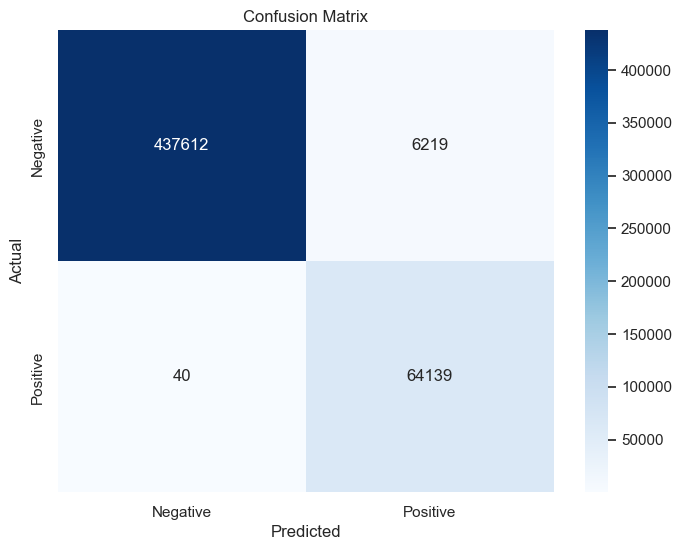

In [54]:
print('SMOTE')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

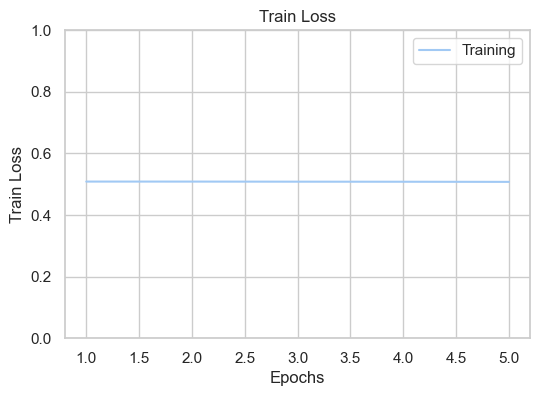

In [55]:
def plot_metrics(metric, epochs, title):
    """
    Plot the training metrics.

    Parameters:
    - metric (list): Training metric (e.g., train_loss).
    - epochs (int): The number of epochs.
    - title (string): The title of the plot (imputes the category with type of plot).
    """
    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, epochs + 1), metric, label='Training', color=sns.color_palette("pastel")[0])
    plt.xlabel('Epochs')
    plt.ylabel(f"{title}")
    plt.title(f"{title}")
    plt.legend()
    plt.ylim(0, 1)
    plt.show()
    
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 355.71batch/s]


Test Loss: 0.6548, Test Accuracy: 0.9845, Test F1: 0.9850


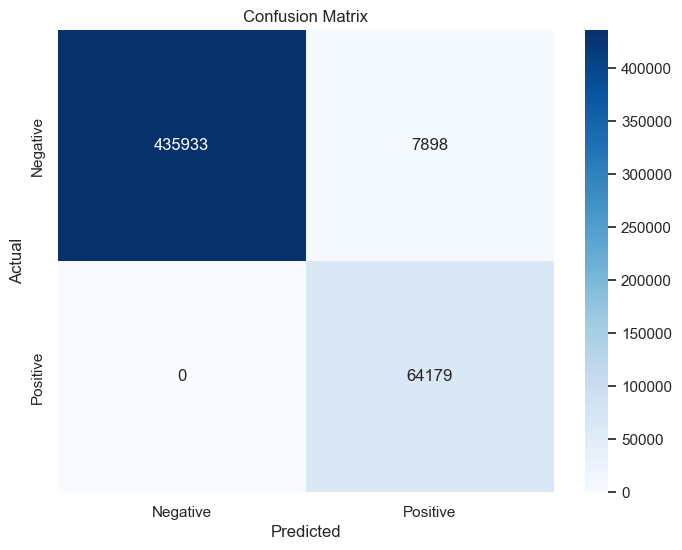

Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 360.12batch/s]


Test Loss: 0.6530, Test Accuracy: 0.9873, Test F1: 0.9877


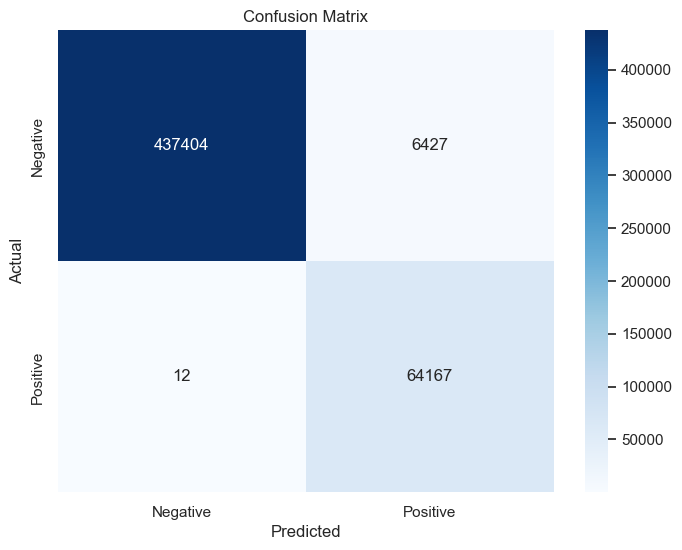

Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 371.62batch/s]


Test Loss: 0.6528, Test Accuracy: 0.9876, Test F1: 0.9880


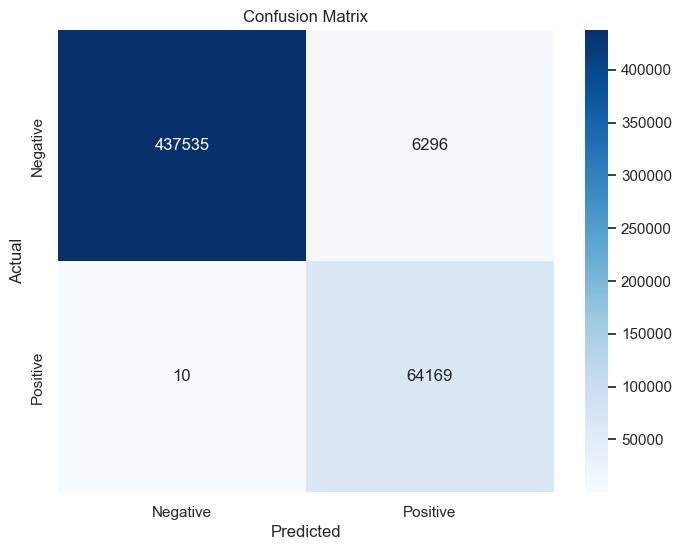

Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 371.10batch/s]


Test Loss: 0.6526, Test Accuracy: 0.9879, Test F1: 0.9883


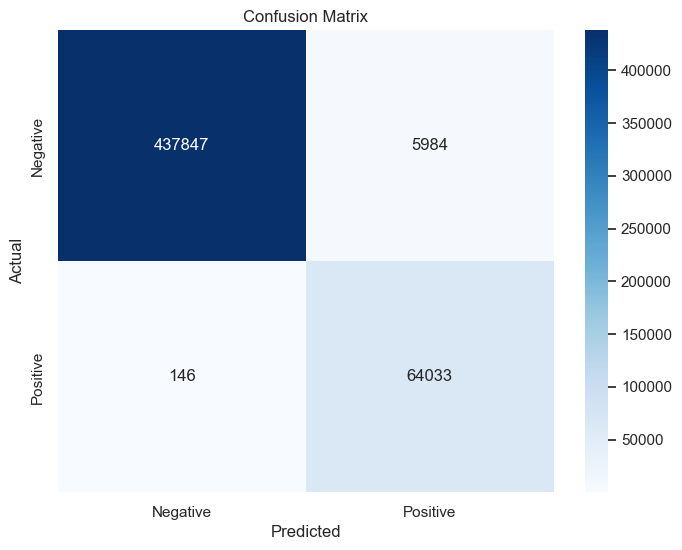

Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 358.69batch/s]


Test Loss: 0.6528, Test Accuracy: 0.9877, Test F1: 0.9881


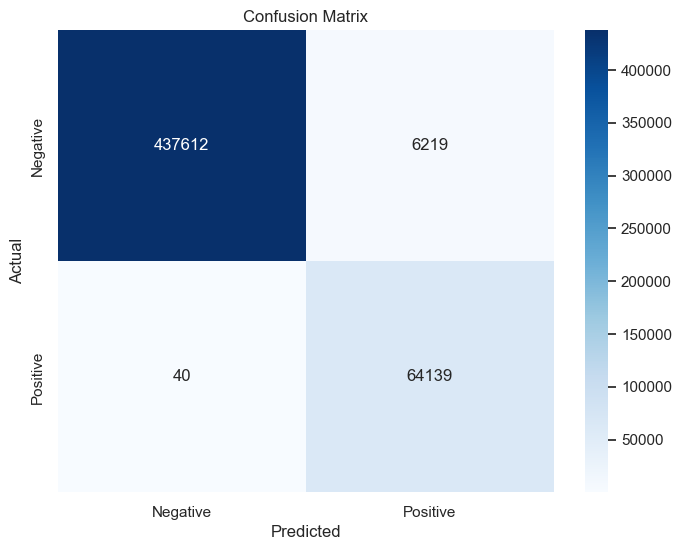

In [ ]:
for i in range(1, 6):
    path = f"./saved_models/PB_epoch_{i}.pkl"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader, criterion)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []